Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5463 - loss: 1.1289 - val_accuracy: 0.8651 - val_loss: 0.4247
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8465 - loss: 0.4520 - val_accuracy: 0.8883 - val_loss: 0.3405
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8759 - loss: 0.3426 - val_accuracy: 0.9046 - val_loss: 0.2997
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9099 - loss: 0.2752 - val_accuracy: 0.8978 - val_loss: 0.2861
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9116 - loss: 0.2687 - val_accuracy: 0.9114 - val_loss: 0.2620


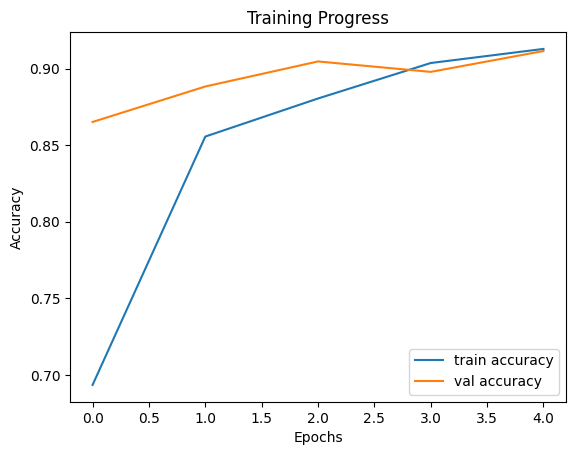

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


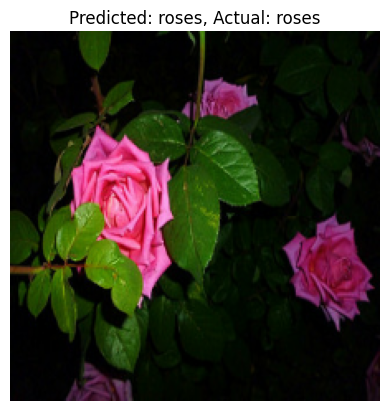

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


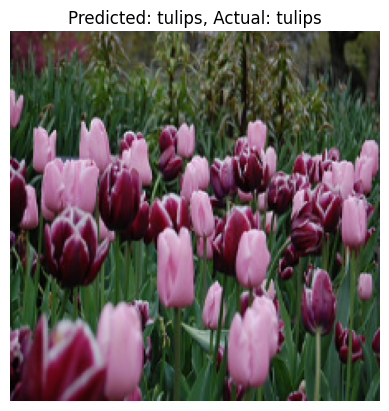

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


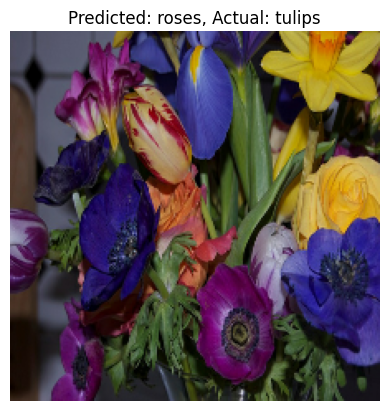

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


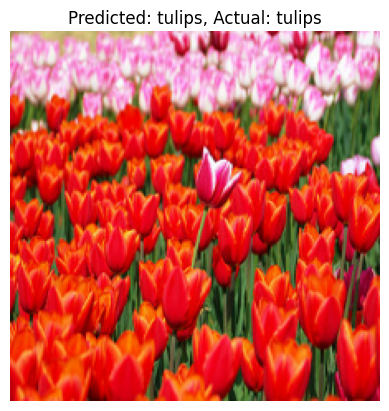

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


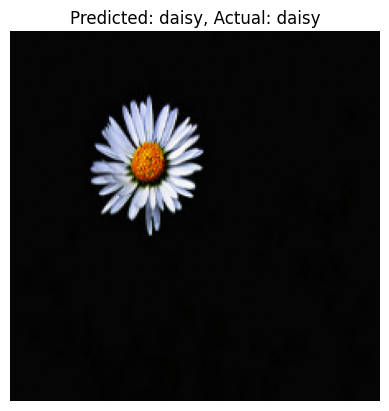

In [2]:
# Import required libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load the Flowers dataset
dataset_name = "tf_flowers"
(train_ds, val_ds), dataset_info = tfds.load(dataset_name, split=['train[:80%]', 'train[80%:]'],
                                             as_supervised=True, with_info=True)

# Function to preprocess images
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Resize and normalize
    return image, label

# Apply preprocessing
train_ds = train_ds.map(format_image).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_image).batch(32).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2 from TensorFlow Hub
mobilenet_v2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(mobilenet_v2_url, input_shape=(224, 224, 3), trainable=False)

# Build the model
# Wrap the feature_extractor in a Lambda layer
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: feature_extractor(x)),  # Wrap in Lambda layer
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer
    tf.keras.layers.Dense(dataset_info.features['label'].num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Progress')
plt.show()

# Test model on a few images
def show_predictions(dataset, model, num_images=5):
    class_names = dataset_info.features['label'].names
    for image, label in dataset.take(num_images):
        pred = model.predict(tf.expand_dims(image, axis=0))
        predicted_class = class_names[np.argmax(pred)]
        actual_class = class_names[label.numpy()]

        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}, Actual: {actual_class}")
        plt.axis('off')
        plt.show()

# Show predictions on validation set
show_predictions(val_ds.unbatch(), model, num_images=5)
